run these code block **sequentially** use shift+Enter

In [1]:
# parameter

BATCH_SIZE = 512
EPOCHS = 100
train_size = 200000
test_size =  100000

In [2]:
import keras
import numpy as np
from numpy import array
import csv
from sklearn.preprocessing import *
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

print("Tensorflow version " + tf.__version__)
print("Keras version " + keras.__version__)

Using TensorFlow backend.


Tensorflow version 1.14.0
Keras version 2.3.1


In [3]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.apply(tf.data.experimental.unbatch()).batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
#     self.axes[0].set_ylim(0, 1.2/self.zoom)
#     self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

the next part is to add train and test data,
click run and upload from local environment

In [4]:
import pandas as pd
df = pd.read_csv('interact_costas2.csv', header=None)

# shuffle data if necessary
# df = df.iloc[0:90000,:]
# df = df.sample(frac=1, axis=0).reset_index(drop=False)


# # format of train/test data
# # [x y z]
# # energy [kJ/mol]
train_cord = df.iloc[0:train_size, 0:3].values
train_cord = train_cord - 0.5
train_label1 = df.iloc[0:train_size, 3].values
train_label1 = np.reshape(train_label1, (train_size, 1))

valid_cord = df.iloc[train_size:(train_size+test_size), 0:3].values
valid_cord = valid_cord - 0.5
valid_label1 = df.iloc[train_size:(train_size+test_size),3].values
valid_label1 = np.reshape(valid_label1, (test_size, 1))



# power transformation of energy
# from train data
scaler = PowerTransformer(method="box-cox")
train_label2 = scaler.fit_transform(train_label1)
valid_label2 = scaler.transform(valid_label1)

# shift = np.min(train_label2)
# print(shift)

train_label = train_label2
valid_label = valid_label2

df2 = pd.DataFrame(np.vstack([train_label, valid_label]))
df2.to_csv('output_transformed_dispersion.csv', index=False, header=False)
# print(np.min(train_label),np.max(train_label), np.min(train_cord), np.max(train_cord), np.mean(train_label))

check train and test data dimensions 

In [5]:
train_cord.shape

(200000, 3)

In [6]:
train_label1.shape

(200000, 1)

In [7]:
valid_cord.shape

(100000, 3)

In [8]:
valid_label1.shape

(100000, 1)

this is the part to set up NN model
sequentially we add layers with # of neurons and activation defined

the shape of the layers will printed in the next section

In [9]:
from keras import models
from keras import layers

network = models.Sequential()
elu = keras.layers.ELU(alpha=5.0)
network.add(layers.Dense(12, activation='elu', input_shape=(train_cord.shape[1],)))
network.add(layers.Dense(12, activation='elu'))
network.add(layers.Dense(6, activation='elu'))
network.add(layers.Dense(6, activation='elu'))
network.add(layers.Dense(1))

this is the part to set up your optimizer for fitting the model
we use Stochastic gradient descent (please refer to documentation for details)

also compile the whole thing with the settings of optimizer, loss function of mean square error, and metrics of mean absolute error

set up a cool learning rate feature to control step of optimization

In [10]:
from keras import optimizers

# All parameter gradients will be clipped to
# a maximum norm of 1.
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

network.compile(optimizer=adam,
                loss='mse',
                metrics=['mae'])

# lr decay function
# def lr_decay(epoch):
  # return 1 * math.pow(0.97, epoch)

# lr schedule callback
# lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
# plot_learning_rate(lr_decay, EPOCHS)


# print model layers
network.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


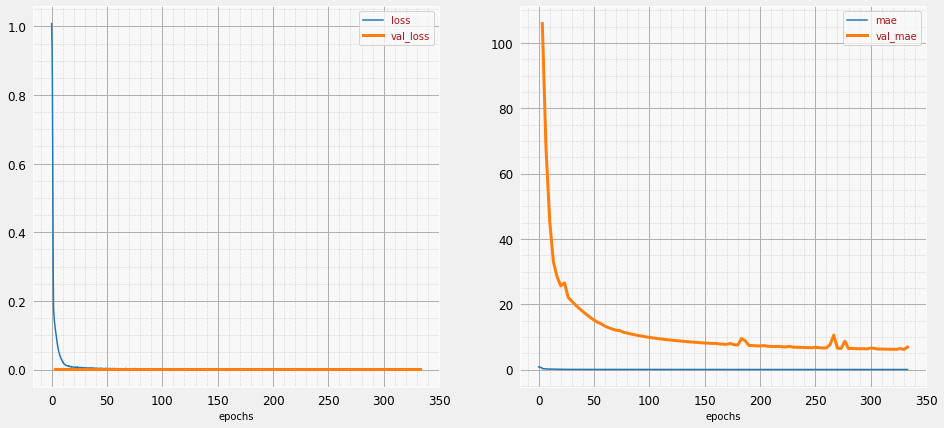

In [11]:
steps_per_epoch = train_size//BATCH_SIZE 
print("Steps per epoch: ", steps_per_epoch)

keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=50, verbose=0, 
                                        mode='auto', baseline=None, restore_best_weights=True)

history = network.fit(train_cord, train_label, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=(valid_cord, valid_label), validation_steps=steps_per_epoch, callbacks=[plot_training])


In [12]:
# for layer in network.layers:
#     weights = layer.get_weights()
#     print(*(node for node in weights))# ( for node in layer.get_weights())

from __future__ import print_function

import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.

    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                subkeys = param.keys()
                for k_name in param.keys():
                    print("      {}/{}: {}".format(p_name, k_name, param.get(k_name)[:]))
    finally:
        f.close()

network.save_weights('dispersion_weights.h5')
print_structure('dispersion_weights.h5')

dispersion_weights.h5 contains: 
Root attributes:
  backend: b'tensorflow'
  keras_version: b'2.3.1'
  layer_names: [b'dense_1' b'dense_2' b'dense_3' b'dense_4' b'dense_5']
  dense_1
    Attributes:
      weight_names: [b'dense_1/kernel:0' b'dense_1/bias:0']
    Dataset:
      dense_1/bias:0: [-0.25775275  0.28678876  0.2643439   0.46315253  0.0933755   0.18621105
  0.11812165  0.2096263   0.37231186  0.23732908  0.10760377  0.5671652 ]
      dense_1/kernel:0: [[-0.0681802  -0.90260804 -1.1975281  -1.0764484   0.82253176 -0.01509103
   0.33916536  0.20835264  0.09374586 -0.06459437  0.09469884  0.72231585]
 [-1.1537647  -0.12805061 -0.03898297 -0.8994334   0.33160818 -0.11977405
  -0.4280098   0.7566124   0.8953221   1.4053131   0.567035   -1.3041838 ]
 [ 0.58220226  0.8322852  -0.5638586  -0.12346685 -0.40961432  1.4419625
  -1.0433028   0.82048506 -0.02006174 -0.0162726   1.2381089   0.42953408]]
  dense_2
    Attributes:
      weight_names: [b'dense_2/kernel:0' b'dense_2/bias:0']
  

In [15]:
train_pred = network.predict(train_cord)
valid_pred = network.predict(valid_cord)

train_pred_inverse = scaler.inverse_transform(train_pred)
valid_pred_inverse = scaler.inverse_transform(valid_pred)
print(df[0:10])
print(train_pred_inverse[0:10])

        0       1       2            3
0  0.5000  0.5000  0.5000    20.643788
1  0.7500  0.2500  0.7500   165.150439
2  0.2500  0.7500  0.2500   165.150439
3  0.3750  0.3750  0.6250    29.461536
4  0.8750  0.8750  0.1250  9718.982990
5  0.6250  0.1250  0.3750    56.677883
6  0.1250  0.6250  0.8750   217.050330
7  0.1875  0.3125  0.3125    96.833231
8  0.6875  0.8125  0.8125   225.419932
9  0.9375  0.0625  0.5625   161.862947
[[  20.150671]
 [ 162.73184 ]
 [ 162.36967 ]
 [  29.892277]
 [9834.02    ]
 [  55.365776]
 [ 208.19199 ]
 [  94.77525 ]
 [ 225.6054  ]
 [ 158.53745 ]]


In [14]:
df3 = pd.DataFrame(np.vstack([train_pred_inverse,valid_pred_inverse]))
df3.to_csv('dispersion_total_pred_inverse.csv', index=False, header=False)